In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.decomposition import PCA
from google.colab import drive

#mount drive
drive.mount('/content/drive')

#change directory
%cd /content/drive/MyDrive/Colab Notebooks/Honeypot_analysis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/SecurityProject-5a375e71139942a7491cd5553b9764c34261534c


In [ ]:
#available windows
windows=[10, 60, 180, 600]

TCP_FILE_NAME='data_tcp'
UDP_FILE_NAME='data_udp'
ICMP_FILE_NAME='data_icmp'

#features
feature1 = 'ts'
feature2 = 'src_ip'
feature3 = 'src_port'
feature4 = 'dst_ip'
feature5 = 'dst_port'
feature6 = 'pck_len'
feature7 = 'tcp_flags'
feature8 = 'cluster'
feature9 = 'user'
feature10 = 'num_attack'
feature11 = 'first_port_scan'
feature12 = 'ip_diff'
feature13 = 'port_diff'
feature14 = 'range_ip'
feature15 = 'range_port'
feature16 = 'ip_medium'
feature17 = 'ip_std'
feature18 = 'port_medium'
feature19 = 'port_std'
feature20 = 'pck_medium'
feature21 = 'pck_std'

In [ ]:
def choose_window(proto):
  print("Choose a time window for", proto)

  user_input=False
  while not (user_input):
    for j in range(0, len(windows)):
      print(str(j+1)+") "+str(windows[j]))

    try:
      user_input = int(input(""))

      if user_input >=1 and user_input <= len(windows):
        window_chosen=windows[user_input-1]
      else:
        print ("\nChoose Well\n")
        user_input=False

    except ValueError:
      print('\nInvalid number!\n')

  return window_chosen


#read data 
def read_data(fname):
  stream = os.popen("find . -name '%s'" % fname)
  fpath = stream.read()[:-1]
  data_original= pd.read_csv(fpath)

  return data_original


#set optimal cluster parameters
class Cluster_parameters:
    def __init__(self, num_cluster=3):
        self.num_cluster = num_cluster


#display created clusters
def print_clusters(df, labels, num_cluster=10, title=''):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
  labels_df = pd.DataFrame(labels, columns=['cluster']) 
  final_df = pd.concat([principalDf, labels_df[['cluster']]], axis = 1)
  final_df.dropna(inplace=True)
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(title, fontsize = 20)
  targets = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
  colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'darkorange', 'darkblue', 'pink']
  i=1
  for target, color in zip(targets,colors):
      indicesToKeep = final_df['cluster'] == target
      ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
                , final_df.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
      i=i+1
      if i>num_cluster:
        break
  ax.legend(targets)
  ax.grid()
  

# calculate clusters
def cluster(df, features, _n_clusters=3):
  #rescaling dataset and setting feature
  df_rescaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

  #clusters creation with k-means
  kmeans = KMeans(n_clusters=_n_clusters)

  labels = kmeans.fit_predict(df_rescaled[features])
  #label assignment 
  df_rescaled['cluster'] = labels

  #calculate clusters' size
  detail = df_rescaled.groupby(['cluster']).size()

  return df_rescaled, labels, detail

# TCP Cluster

In [ ]:
#choose time window
tcp_window=choose_window("TCP")

#set file name 
file_tcp=TCP_FILE_NAME+"_"+str(tcp_window)+".csv"

#read data 
data_tcp_original=read_data(file_tcp)

#drop duplicates
data_tcp_rm = data_tcp_original.drop_duplicates(subset=['user'])

Choose a time window for TCP
1) 10
2) 60
3) 180
4) 600
3


In [ ]:
tcp_parameters={}

#set parameters 
tcp_parameters[10]=Cluster_parameters(2)  
tcp_parameters[60]=Cluster_parameters(2)  
tcp_parameters[180]=Cluster_parameters(2) #1°
tcp_parameters[600]=Cluster_parameters(2) #2°

In [ ]:
#features for clustering
tcp_features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  rescaled_data_tcp_rm, tcp_labels, detail=cluster(data_tcp_rm, tcp_features, actual_param.num_cluster)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_tcp_rm, tcp_labels, detail=cluster(data_tcp_rm, tcp_features)

print("TCP cluster's details\n", detail)

TCP cluster's details
 cluster
0    24360
1      117
dtype: int64



*Performance* 



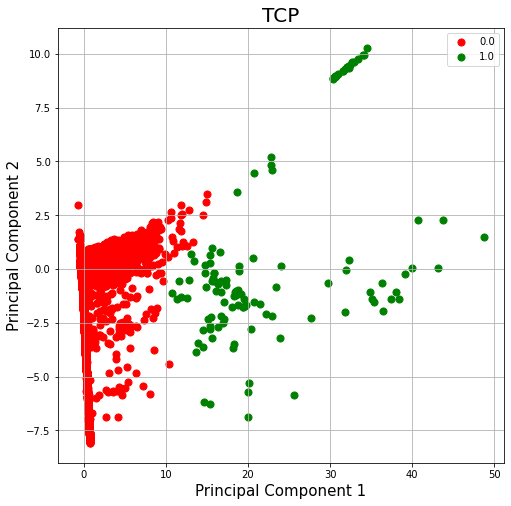

In [ ]:
#print clusters
if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  print_clusters(rescaled_data_tcp_rm[tcp_features], tcp_labels, actual_param.num_cluster, "TCP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_tcp_rm[tcp_features], tcp_labels)

In [ ]:
score_tcp = silhouette_score(rescaled_data_tcp_rm[tcp_features],tcp_labels)
print(score_tcp)

0.9028214561733827


In [ ]:
#definitive cluster assignment
data_tcp_rm['cluster']=tcp_labels

# UDP Cluster

In [ ]:
#choose time window
udp_window=choose_window("UDP")

#set file name 
file_udp=UDP_FILE_NAME+"_"+str(udp_window)+".csv"

#read data 
data_udp_original=read_data(file_udp)

#drop duplicates
data_udp_rm = data_udp_original.drop_duplicates(subset=['user'])

Choose a time window for UDP
1) 10
2) 60
3) 180
4) 600
1


In [ ]:
udp_parameters={}

#set parameters 
udp_parameters[10]=Cluster_parameters(3) #best  
udp_parameters[60]=Cluster_parameters(3)  
udp_parameters[180]=Cluster_parameters(3)
udp_parameters[600]=Cluster_parameters(3)

In [ ]:
#features for clustering
udp_features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  rescaled_data_udp_rm, udp_labels, detail=cluster(data_udp_rm, udp_features, actual_param.num_cluster)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_udp_rm, udp_labels, detail=cluster(data_udp_rm, udp_features)

print("UDP cluster's details\n", detail)

UDP cluster's details
 cluster
0    3825
1       5
2      36
dtype: int64


*Performance*

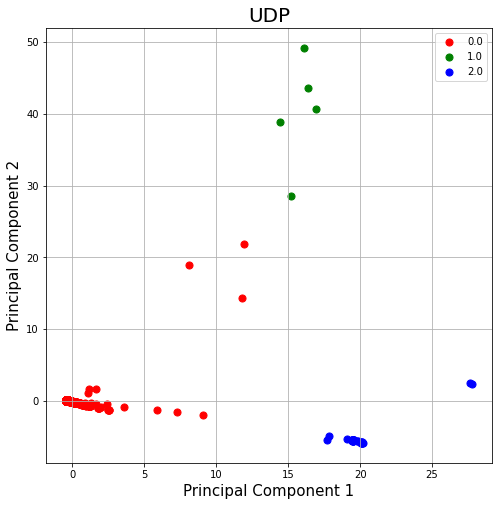

In [ ]:
#print clusters
if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  print_clusters(rescaled_data_udp_rm[udp_features], udp_labels, actual_param.num_cluster, "UDP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_udp_rm[udp_features], udp_labels)

In [ ]:
score_udp = silhouette_score(rescaled_data_udp_rm[udp_features],udp_labels)
print(score_udp)

0.8966718367066381


In [ ]:
#definitive cluster assignment
data_udp_rm['cluster']=udp_labels

# ICMP Cluster

In [ ]:
#choose time window
icmp_window=choose_window("ICMP")

#set file name 
file_icmp=ICMP_FILE_NAME+"_"+str(icmp_window)+".csv"

#read data 
data_icmp_original=read_data(file_icmp)

#drop duplicates
data_icmp_rm = data_icmp_original.drop_duplicates(subset=['user'])

Choose a time window for ICMP
1) 10
2) 60
3) 180
4) 600
2


In [ ]:
icmp_parameters={}

#set parameters 
icmp_parameters[10]=Cluster_parameters(2)
icmp_parameters[60]=Cluster_parameters(2) #1°
icmp_parameters[180]=Cluster_parameters(2) #2°  
icmp_parameters[600]=Cluster_parameters(3)

In [ ]:
#features for clustering
icmp_features=[feature10,feature12,feature14,feature16,feature17,feature20,feature21]

if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  rescaled_data_icmp, icmp_labels, detail=cluster(data_icmp_rm, icmp_features, actual_param.num_cluster)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_icmp, icmp_labels, detail=cluster(data_icmp_rm, icmp_features)

print("ICMP cluster's details\n", detail)

ICMP cluster's details
 cluster
0    169
1      1
dtype: int64


*Performance*

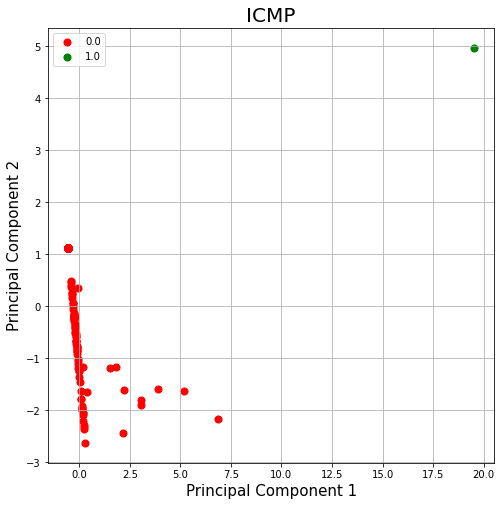

In [ ]:
#print clusters
if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  print_clusters(rescaled_data_icmp[icmp_features], icmp_labels, actual_param.num_cluster, "ICMP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_icmp[icmp_features], icmp_labels)

In [ ]:
score_icmp = silhouette_score(rescaled_data_icmp[icmp_features], icmp_labels)
print(score_icmp)

0.897989415621417


In [ ]:
#definitive cluster assignment
data_icmp_rm['cluster']=icmp_labels

#Old Data

What was done allowed to extract knowledge from the original dataset? Could the identified clusters be identified even without previous data manipulation?

In [ ]:
def set_original_labels(df_new, df_old):
  cluster = []
  map_user = {}
  for index,row in df_new.iterrows():
    map_user[row['user']] = row['cluster']
  for index,row in df_old.iterrows():
    cluster.append(map_user[row['user']])
  cluster_np = np.asarray(cluster)
  cluster = cluster_np.reshape((cluster_np.size,1))
  rescaled_data = pd.DataFrame(StandardScaler().fit_transform(df_old), columns=df_old.columns)
  rescaled_data['cluster'] = cluster 

  return rescaled_data

TCP

Score TCP:  0.09692053409097565


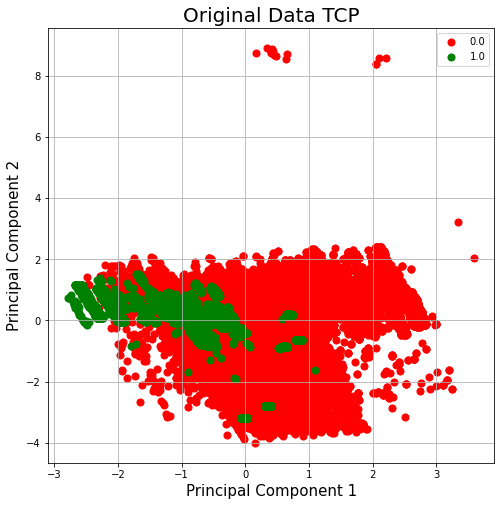

In [ ]:
old_data_tcp = set_original_labels(data_tcp_rm, data_tcp_original)

old_tcp_features=[feature1, feature2, feature3, feature4, feature5, feature6, feature7]

#evaluating clustering perfomances
score_tcp = silhouette_score(old_data_tcp[old_tcp_features], old_data_tcp['cluster'])
print("Score TCP: ", score_tcp)

#print clusters TCP 
if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  print_clusters(old_data_tcp[old_tcp_features], old_data_tcp['cluster'], actual_param.num_cluster, "Original Data TCP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_tcp[old_tcp_features], old_data_tcp['cluster'])

UDP

Score UDP:  0.24869547722877783


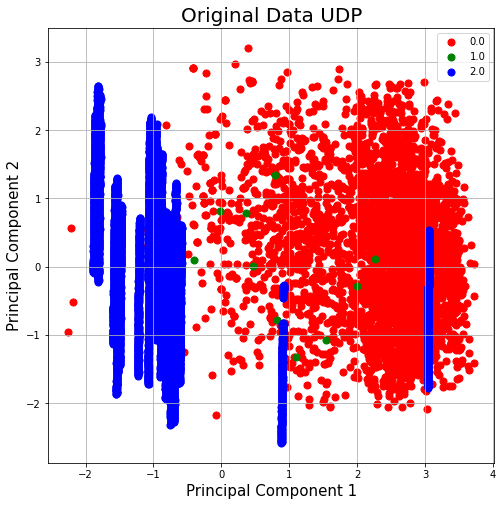

In [ ]:
old_data_udp = set_original_labels(data_udp_rm, data_udp_original)

old_udp_features=[feature1, feature2, feature3, feature4, feature5, feature6]

#evaluating clustering perfomances 
score_udp = silhouette_score(old_data_udp[old_udp_features],old_data_udp['cluster'])
print("Score UDP: ", score_udp)

#print clusters UDP 
if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  print_clusters(old_data_udp[old_udp_features], old_data_udp['cluster'], actual_param.num_cluster, "Original Data UDP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_udp[old_udp_features], old_data_udp['cluster'])

ICMP

Score ICMP:  0.41397926721482037


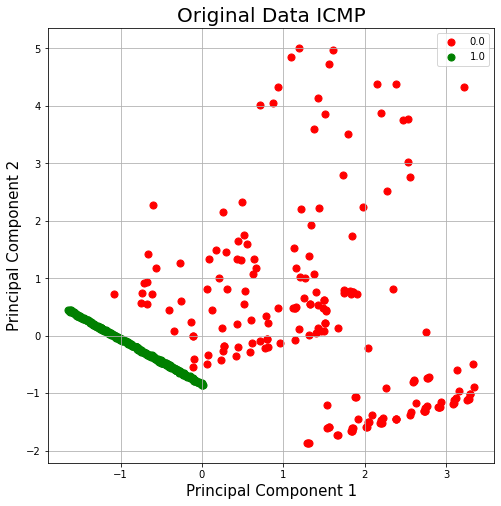

In [ ]:
old_data_icmp = set_original_labels(data_icmp_rm, data_icmp_original)

old_icmp_features=[feature1, feature2, feature4, feature6]

#evaluating clustering perfomances 
score_icmp = silhouette_score(old_data_icmp[old_icmp_features],old_data_icmp['cluster'])
print("Score ICMP: ",score_icmp)

#print clusters ICMP (old data)
if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  print_clusters(old_data_icmp[old_icmp_features],old_data_icmp['cluster'], actual_param.num_cluster, "Original Data ICMP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_icmp[old_icmp_features],old_data_icmp['cluster'])

# Early Classification Performance

In [ ]:
def get_accuracy_early_classification(df, partition):
  true_label = df['cluster'] 
  data_cluster = df.loc[(df['cluster'] == partition)]
  port_cluster = data_cluster['first_port_scan'].drop_duplicates().tolist()
  unlabeled_data = df.drop(['cluster'],axis=1)
  pred_label = []
  for index,row in df.iterrows():
    if row['dst_port'] in port_cluster:
      pred_label.append(partition)
    else:
      pred_label.append(-1)
  pred_label_np = np.asarray(pred_label)
  pred_label_np = pred_label_np.reshape((pred_label_np.size,1))    
  for label in true_label:
    if label != partition:
      label = -1
  accuracy =   accuracy_score(true_label,pred_label_np)
  return accuracy 

TCP

In [ ]:
print('Accuracy for TCP')
actual_param=tcp_parameters[tcp_window]
num_cluster=actual_param.num_cluster
for i in range (0,num_cluster):
  accuracy = get_accuracy_early_classification(data_tcp_rm, i)
  print('modus operandi',i,': ',accuracy)

Accuracy for TCP
modus operandi 0 :  0.9952200024512808
modus operandi 1 :  0.004779997548719206


UDP

In [ ]:
print('Accuracy for UDP')
actual_param=udp_parameters[udp_window]
num_cluster=actual_param.num_cluster
for i in range (0,num_cluster):
  accuracy = get_accuracy_early_classification(data_udp_rm, i)
  print('modus operandi',i,': ',accuracy)

Accuracy for UDP
modus operandi 0 :  0.9893947232281428
modus operandi 1 :  0.0012933264355923435
modus operandi 2 :  0.009311950336264873
